In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

my_dir=r'/home/behemoth/housing.csv'
housing = pd.read_csv(my_dir)

mapping={'INLAND':1, 'NEAR OCEAN':2, '<1H OCEAN':3, 'NEAR BAY':4, 'ISLAND':5}

df= pd.DataFrame(housing)
housing=df.replace({'ocean_proximity': mapping})

In [2]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  
0       322.0       126.0         8.3252            452600.0                4  
1      2401.0      1138.0         8.3014            358500.0                4  
2       496.0       177.0         7.2574            352100.0                4  
3       558.0       219.0         5.6431            341300.0                4  
4       565.0       259.0         3.8462            342200.0                4

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


In [4]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  ocean_proximity  
count        20640.000000     20640.000000  
mean        206855.816909         2.347868  
std         115395.615874         1.041656  
min          14999.000000         1.000000  
25%         119600.000000         1.000000  
50%         179700.000000         3.000000  
75%         264725.000000         3.000000  
max         500001.000000         5.000000

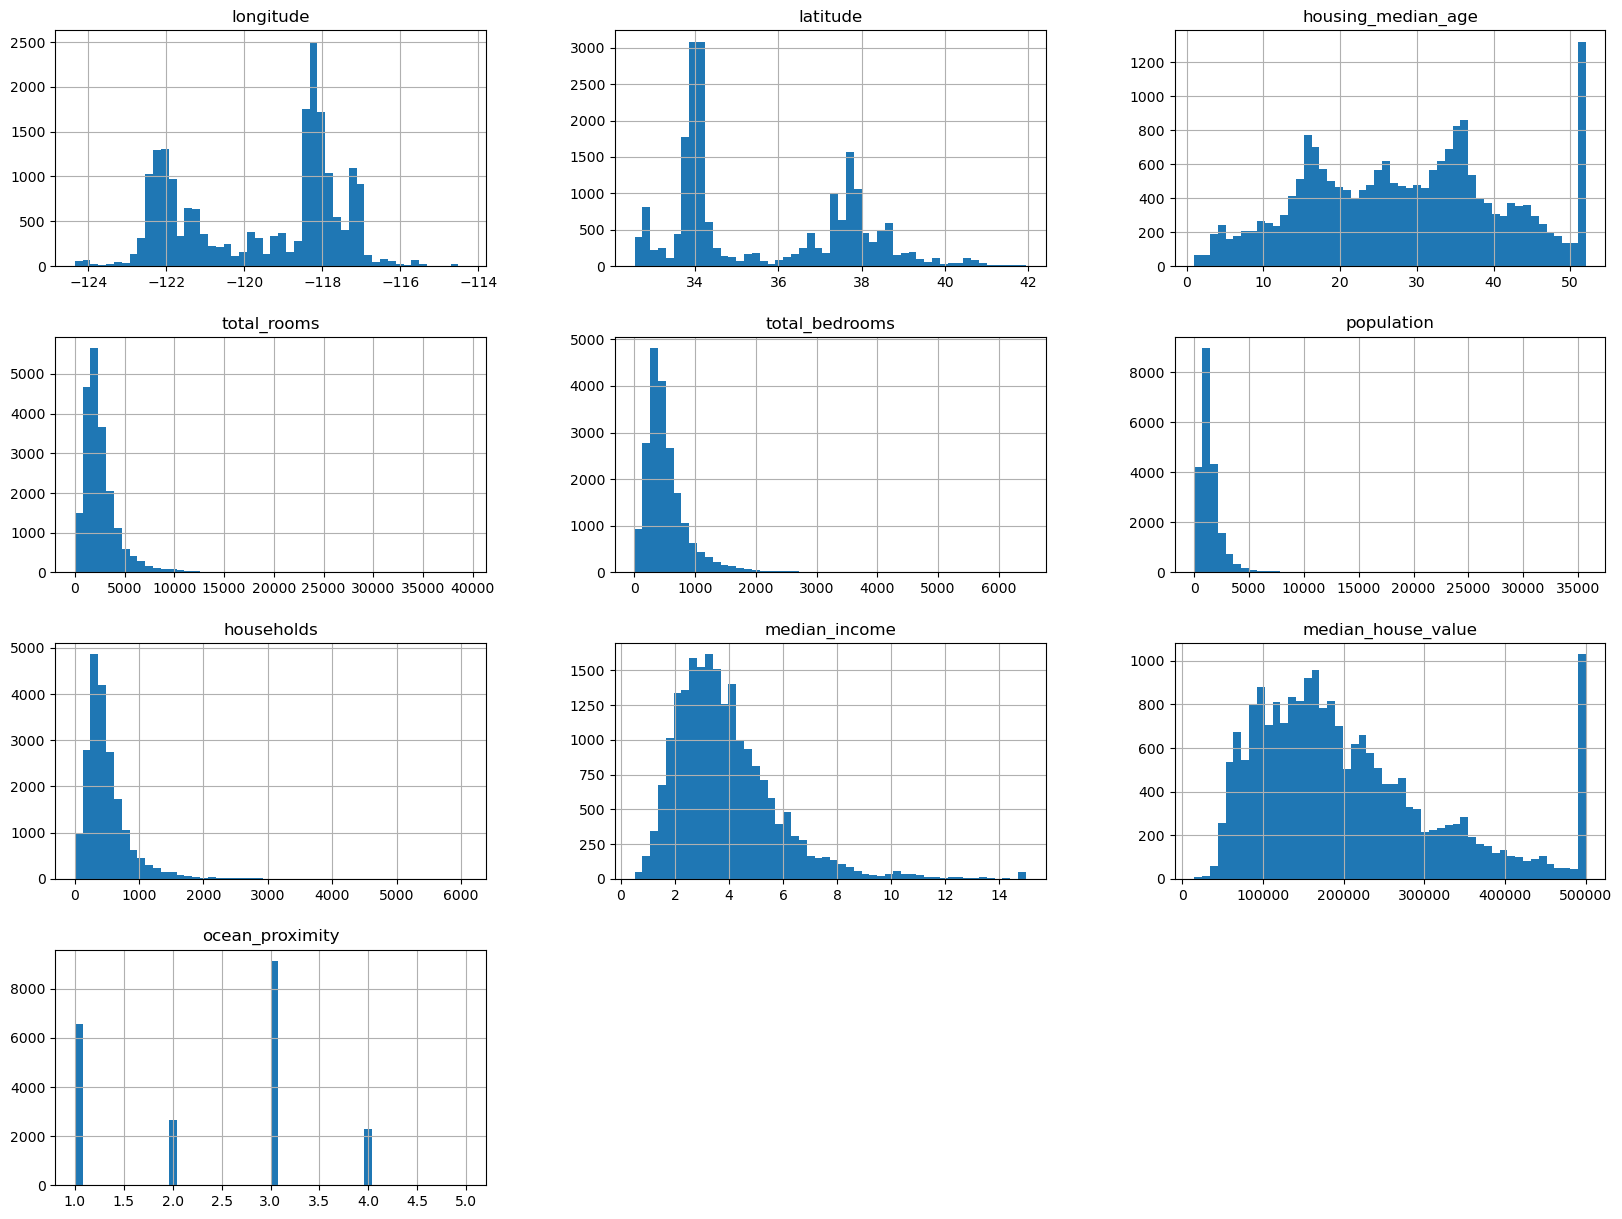

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [6]:
import numpy as np

#This method will split the dataset into a test and train set
def split_train_test(data, test_ratio):
    shuffled_indices= np.random.permutation(len(data))
    test_set_size= int(len(data)* test_ratio)
    test_indices= shuffled_indices[:test_set_size]
    train_indices= shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set,test_set= split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [7]:
#instance identifier used to decide whether it should be in the test or train set 
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash= hashlib.md5):
    ids=data[id_column]
    in_test_set= ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

#splitting the dataset
housing_with_id= housing.reset_index()
train_set, test_set= split_train_test_by_id(housing_with_id, 0.2, "index")

In [8]:
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

In [9]:
#Stratified sampling basing on income category
from sklearn.model_selection import StratifiedShuffleSplit

split= StratifiedShuffleSplit(n_splits=1, test_size= 0.2, random_state= 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set= housing.loc[train_index]
    strat_test_set=housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

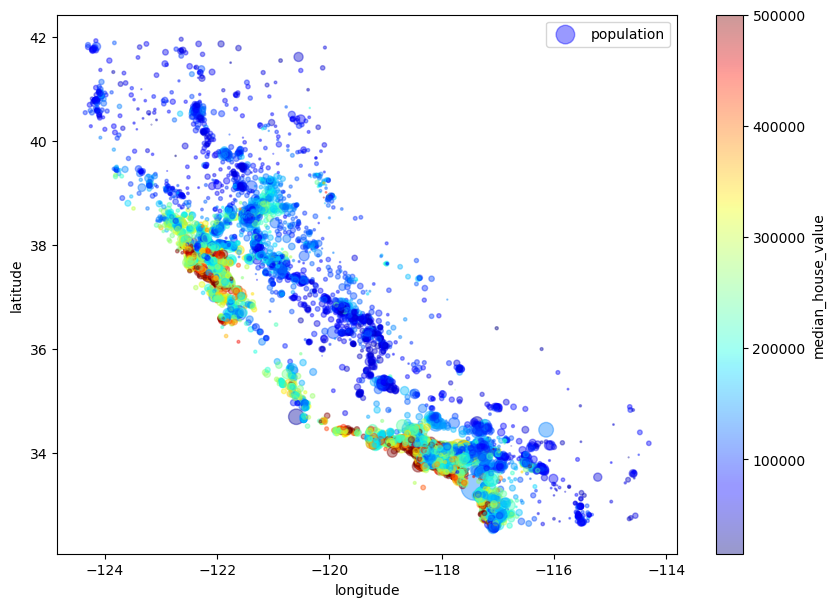

In [11]:
%matplotlib inline
#Visualize and discover data for insightful gain
#copy the training set

housing= strat_train_set.copy()

#Visualizing visual data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha= 0.4, s= housing["population"]/100, label="population",
            figsize=(10, 7), c="median_house_value", cmap= plt.get_cmap("jet"), colorbar=True)
plt.legend()

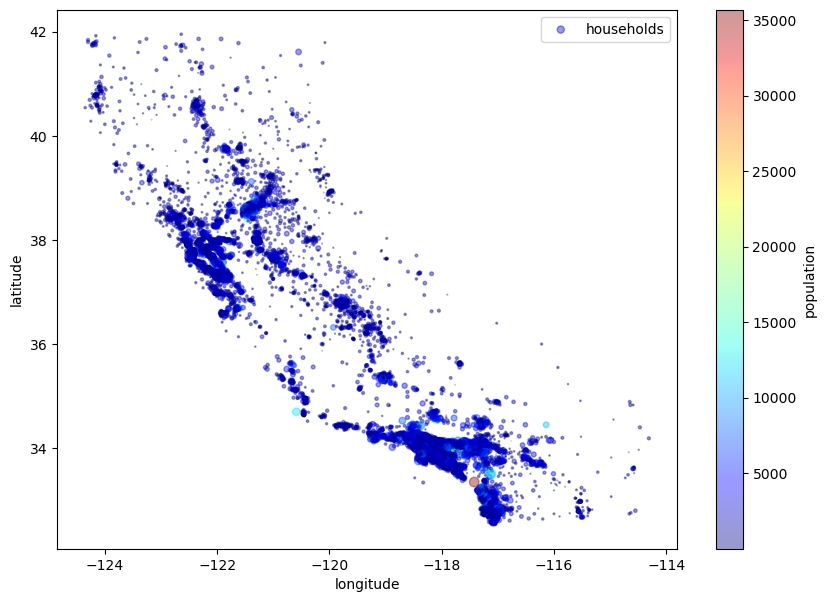

In [12]:
%matplotlib inline
#Visualize and discover data for insightful gain
#copy the training set

housing= strat_train_set.copy()

#Visualizing visual data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha= 0.4, s= housing["households"]/100, label="households",
            figsize=(10, 7), c="population", cmap= plt.get_cmap("jet"), colorbar=True)
plt.legend()

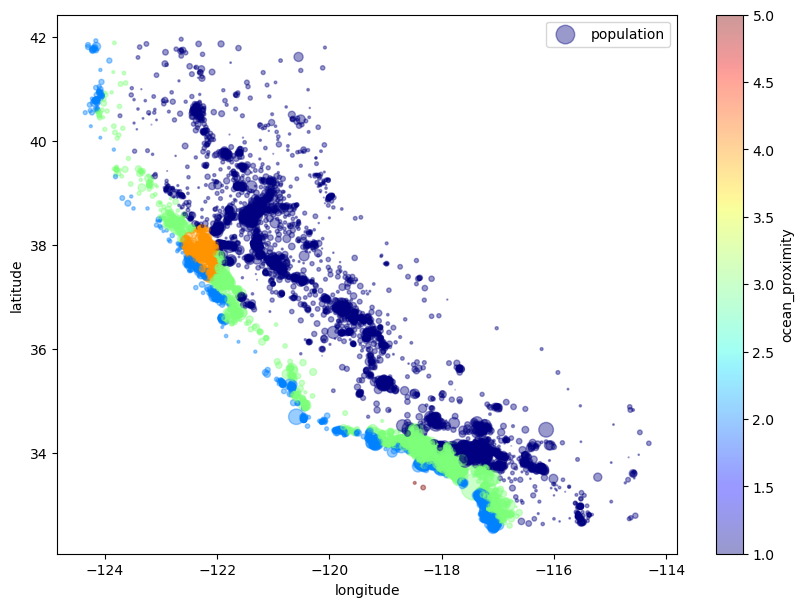

In [13]:
%matplotlib inline
#Visualize and discover data for insightful gain
#copy the training set

housing= strat_train_set.copy()

#Visualizing visual data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha= 0.4, s= housing["population"]/100, label="population",
            figsize=(10, 7), c="ocean_proximity", cmap= plt.get_cmap("jet"), colorbar=True)
plt.legend()

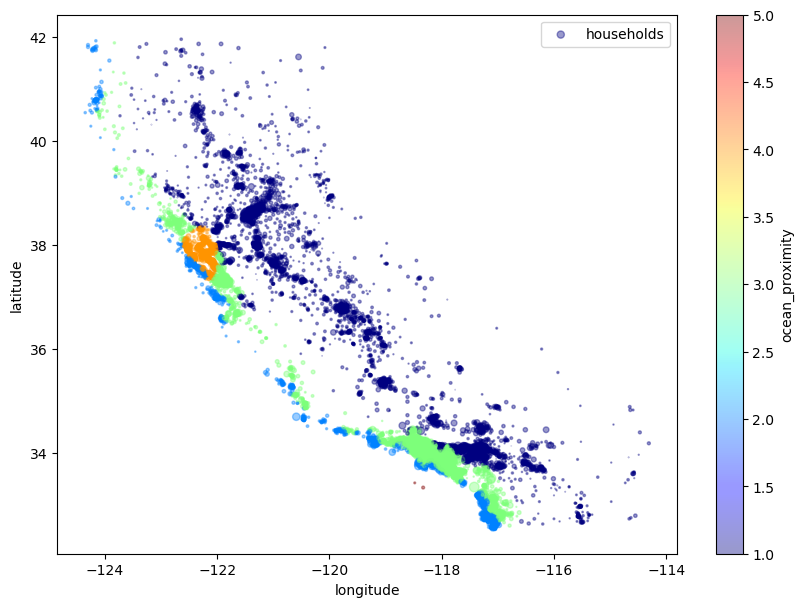

In [14]:
%matplotlib inline
#Visualize and discover data for insightful gain
#copy the training set

housing= strat_train_set.copy()

#Visualizing visual data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha= 0.4, s= housing["households"]/100, label="households",
            figsize=(10, 7), c="ocean_proximity", cmap= plt.get_cmap("jet"), colorbar=True)
plt.legend()

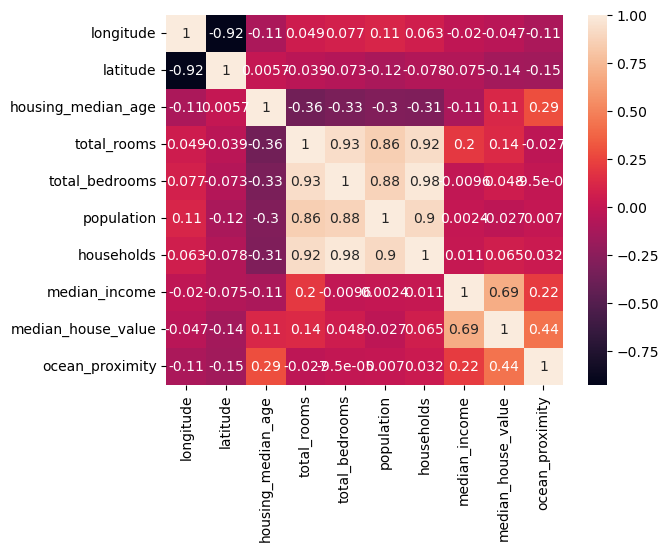

In [15]:
#Looking for correlations in the dataset and correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix= housing.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

sns.heatmap(corr_matrix, annot=True)
plt.show()

<AxesSubplot:>

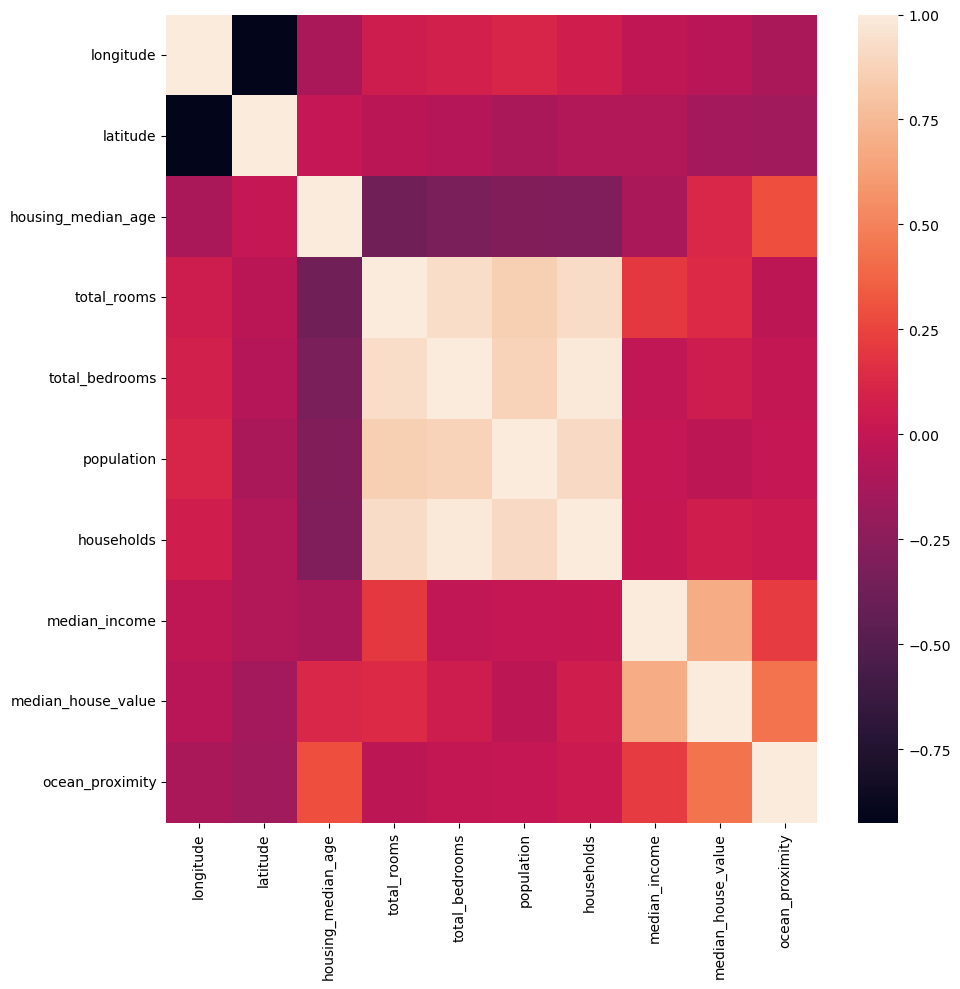

In [16]:
#heat map 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

sns.heatmap(corr_matrix)

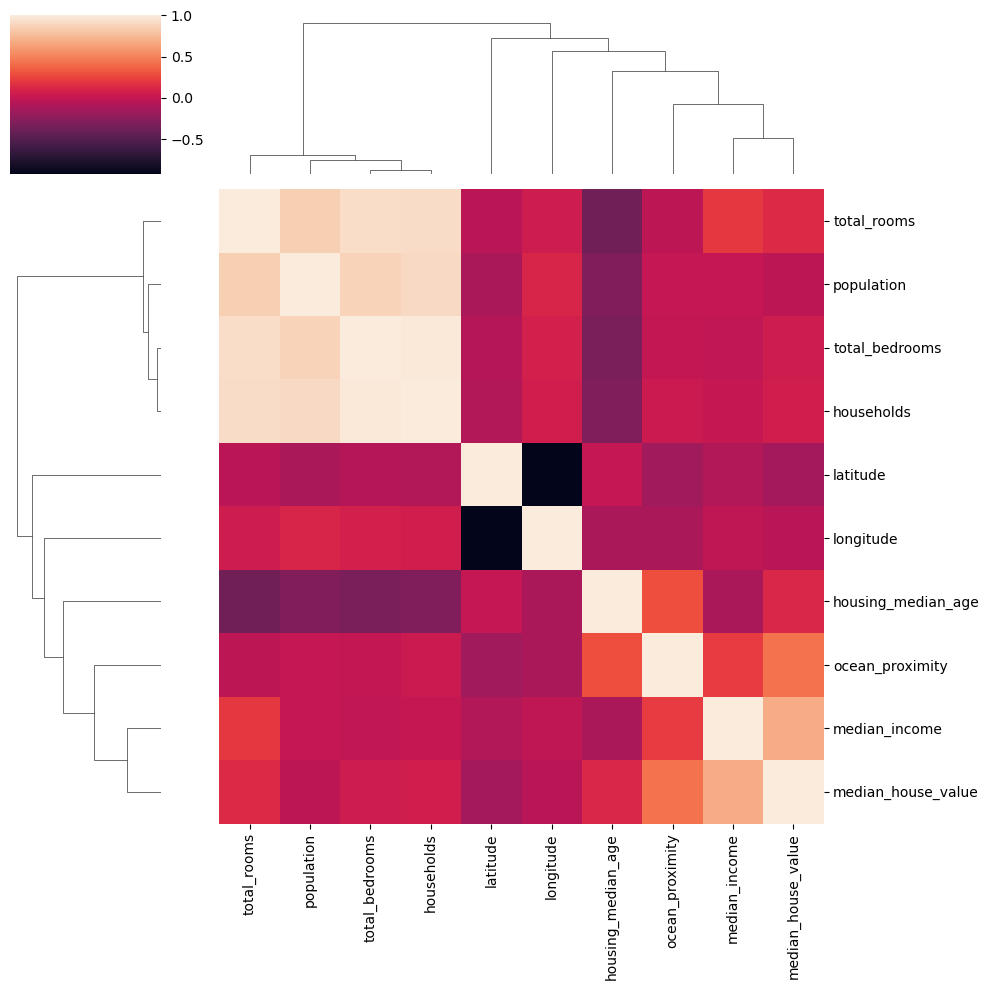

In [17]:
#heat map with clustering
sns.clustermap(corr_matrix)

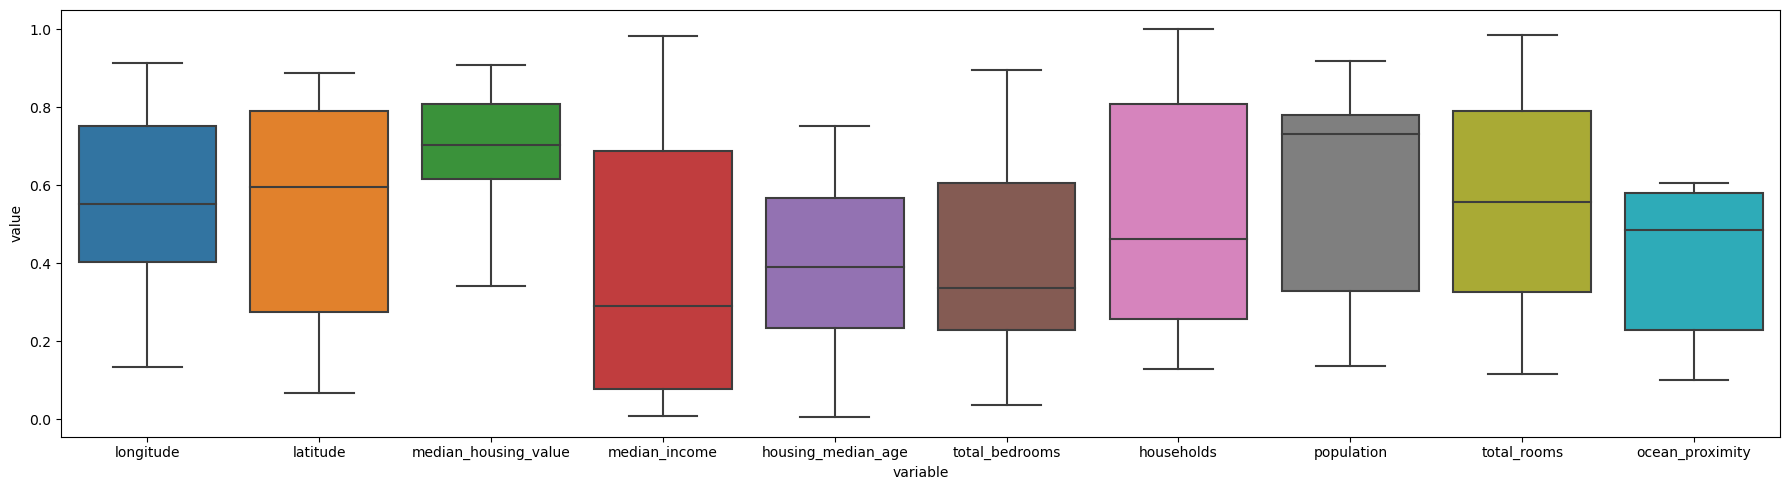

In [18]:
#Box plots for the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams["figure.figsize"] = [18, 5]
plt.rcParams["figure.autolayout"] = True

df = pd.DataFrame(data = np.random.random(size=(10,10)), columns = ['longitude', 'latitude', 'median_housing_value',
                                                                    'median_income','housing_median_age', 
                                                                    'total_bedrooms' ,'households','population',
                                                                    'total_rooms','ocean_proximity'])

sns.boxplot(x="variable", y="value", data=pd.melt(df))

plt.show()

In [19]:
#Outliers in a Histogram

import pandas as pd
import numpy as np
import plotly.express as px

fig = px.histogram(housing, ['longitude', 'latitude', 'housing_median_age'])

fig.show()


array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

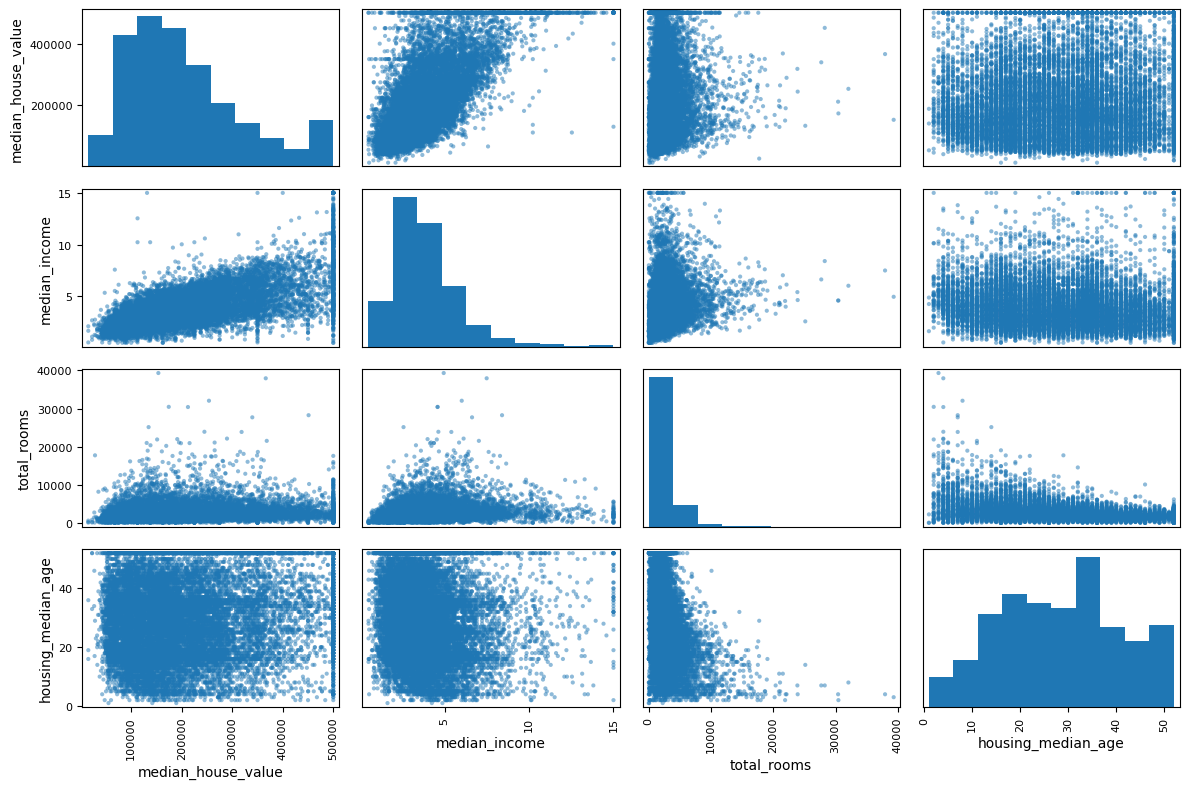

In [20]:
#Using the scatter matrix
from pandas.plotting import scatter_matrix

attributes=["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

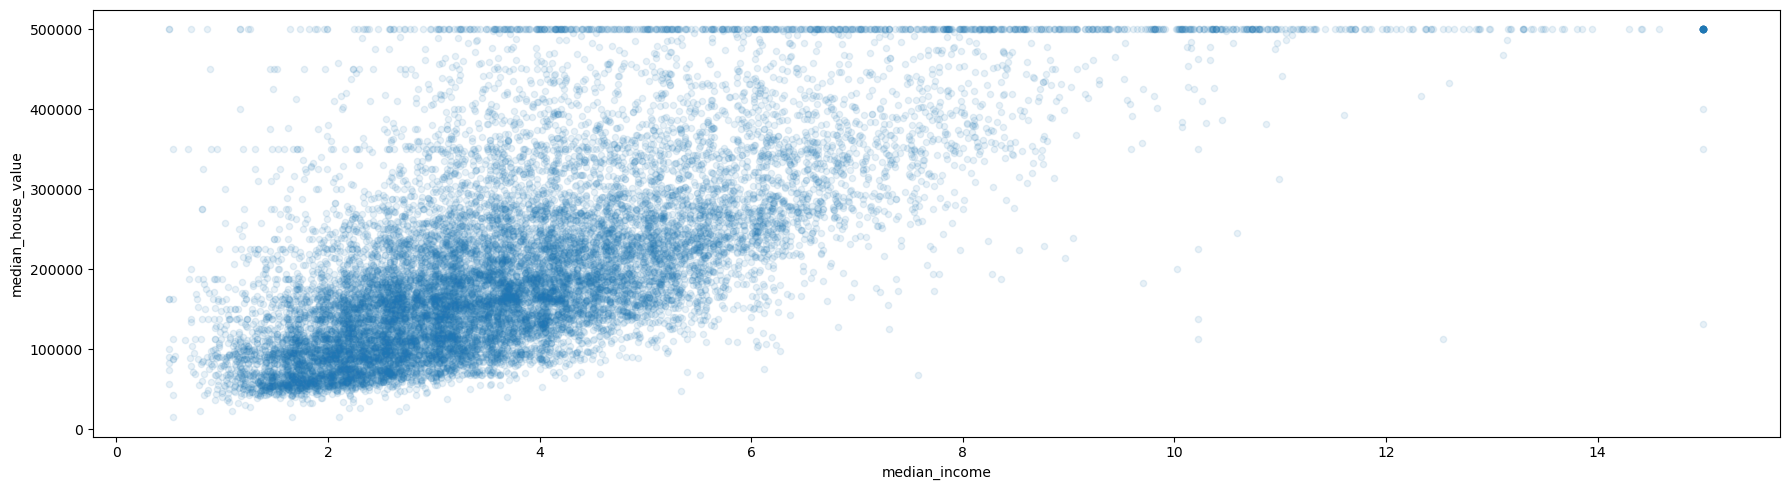

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha= 0.1)

In [22]:
#Experimenting with attribute combinations
housing["rooms_per_household"]= housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]= housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]= housing["population"]/housing["households"]

corr_matrix= housing.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.687151
ocean_proximity             0.435542
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

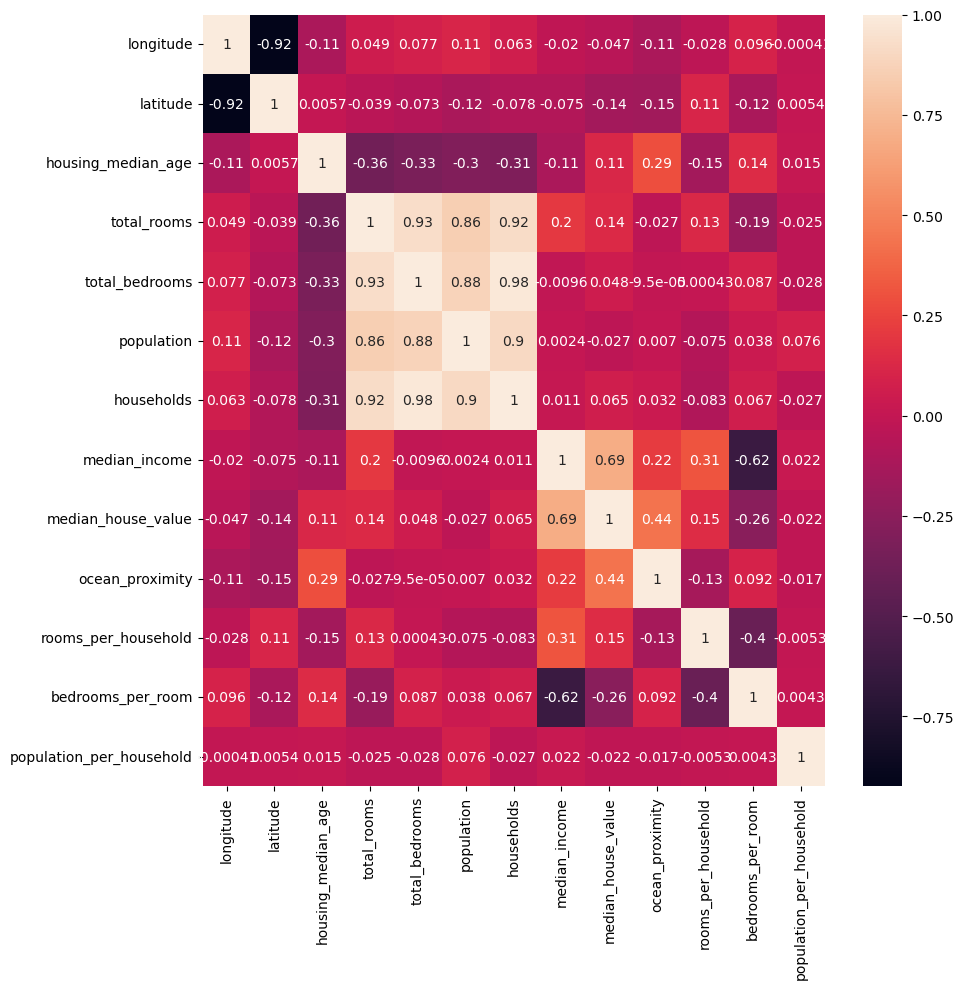

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

sns.heatmap(corr_matrix, annot=True)
plt.show()

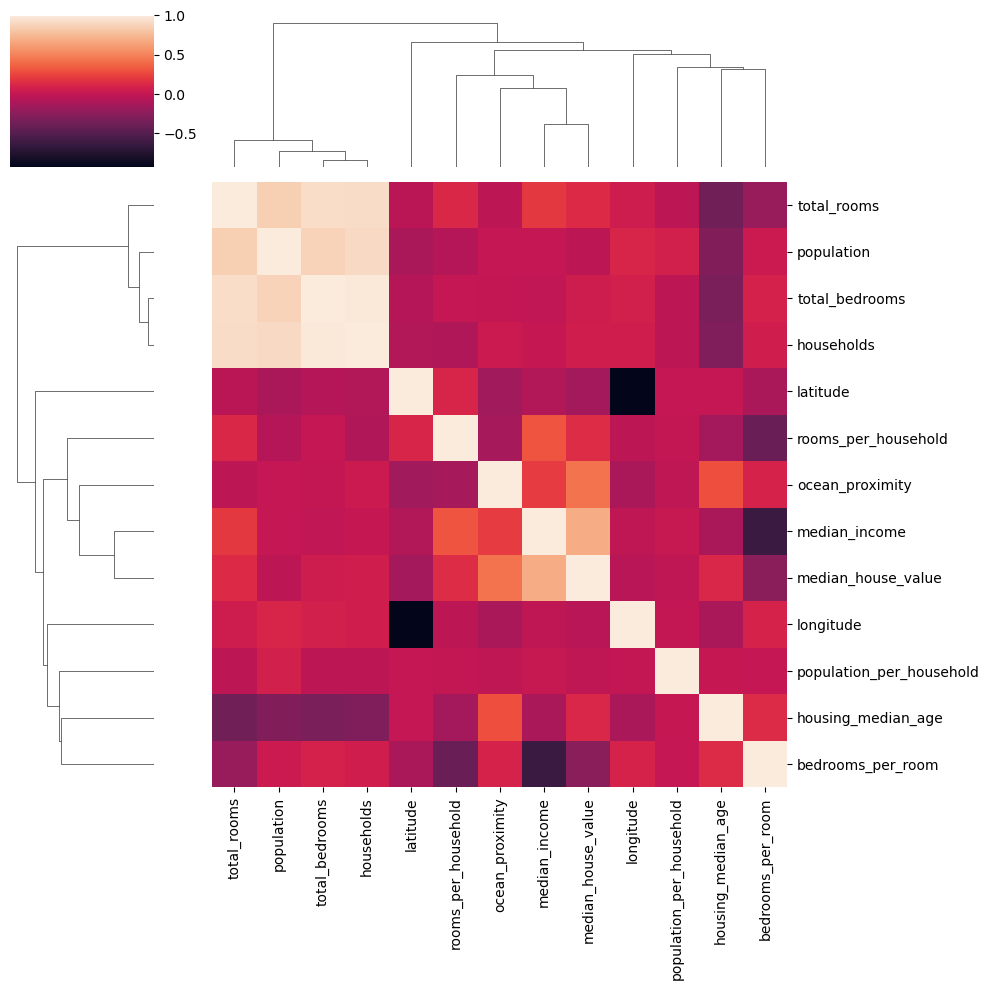

In [65]:
sns.clustermap(corr_matrix)

In [24]:
#Preparing the data for the Machine learning algorithms
housing= strat_train_set.drop("median_house_value", axis=1)
housing_labels= strat_train_set["median_house_value"].copy()

In [25]:
#Data Cleaning
median= housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [26]:
from sklearn.impute import SimpleImputer

imputer= SimpleImputer(strategy="median")
housing_num= housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [27]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [28]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [29]:
X= imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns)

In [30]:
#Handling text and categorical data
housing_cat= housing["ocean_proximity"]
housing_cat.head(10)

12655    1
15502    2
2908     1
14053    2
20496    3
1481     4
18125    3
5830     3
17989    3
4861     3
Name: ocean_proximity, dtype: int64

In [31]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder= OrdinalEncoder()
housing_cat_encoded= ordinal_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_encoded[:20640]

array([[0.],
       [1.],
       [0.],
       ...,
       [2.],
       [2.],
       [0.]])

In [32]:
ordinal_encoder.categories_

[array([1, 2, 3, 4, 5])]

In [33]:
housing_cat_encoded, housing_categories= housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 1, 0, 1, 2, 3, 2, 2, 2, 2])

In [34]:
housing_categories

Int64Index([1, 2, 3, 4, 5], dtype='int64')

In [35]:
import pandas as pd

housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  households  median_income  ocean_proximity  
12655      2237.0       706.0         2.1736                1  
15502      2015.0       768.0         6.3373                2  
2908        667.0       300.0         2.8750                1  
14053       898.0       483.0         2.2264                2  
20496      1837.0       580.0         4.4964                3  
...           ...         ...            ...              ...  
15174      2026.0      1001.0         5.0900                3  
12661      4769.0      1418.0         2.8139                1  
19263       458.0       172.0         3.1797                3  
19140      1208.0       501.0         4.1964                3  
19773       625.0       197.0         3.1319                1  

[16512 rows x 9 columns]

In [36]:
#convert string to integer through encoding
from sklearn.preprocessing import OneHotEncoder

encoder= OneHotEncoder()
housing_cat_1hot= encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
#convert the sparse matrix to a numpy array
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [38]:
#Custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix= 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room= add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household= X[:, rooms_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household]
attr_adder= CombinedAttributesAdder(add_bedrooms_per_room= False)
housing_extra_attribs= attr_adder.transform(housing.values)

In [39]:
#transformation pipelining
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline= Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr= num_pipeline.fit_transform(housing_num)

In [40]:
from sklearn.compose import ColumnTransformer

num_attribs=list(housing_num)
cat_attribs= ["ocean_proximity"]

full_pipeline= ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared= full_pipeline.fit_transform(housing)

In [41]:
#Using the Linear Regression Model
from sklearn.linear_model import LinearRegression

lin_reg= LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [42]:
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared= full_pipeline.transform(some_data)

In [43]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85806.2157108  305390.62200336 151996.97918871 185908.83490813
 244568.86489392]


In [44]:
print("Labels: ", list(some_labels))

Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [45]:
from  sklearn.metrics import mean_squared_error
housing_predictions= lin_reg.predict(housing_prepared)
lin_mse= mean_squared_error(housing_labels, housing_predictions)
lin_rmse= np.sqrt(lin_mse)
lin_rmse

68635.27064635929

In [46]:
#Implementing thedecision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg= DecisionTreeRegressor(max_depth=3, random_state=0)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [47]:
t1= tree_reg.score(housing_prepared, housing_labels)
t2= tree_reg.score(some_data_prepared, some_labels)

print("R^2 of Decision Tree Regressor on training set: {:.3f}".format(t1))
print("R^2 of Decision Tree Regressor on test set: {:.3f}".format(t2))

R^2 of Decision Tree Regressor on training set: 0.567
R^2 of Decision Tree Regressor on test set: 0.867


In [48]:
print("Feature Importance: \n{}".format(tree_reg.feature_importances_))

Feature Importance: 
[0.        0.        0.        0.        0.        0.        0.
 0.7519877 0.        0.        0.2480123 0.        0.        0.
 0.       ]


In [49]:
housing_predictions= tree_reg.predict(housing_prepared)
tree_mse=mean_squared_error(housing_labels, housing_predictions)
tree_rmse= np.sqrt(tree_mse)
tree_rmse

76118.50508259152

In [50]:
#K-fold cross-validation
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg, housing_prepared,housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores= np.sqrt(-scores)

In [51]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [52]:
display_scores(tree_rmse_scores)

Scores:  [79145.60135521 74244.35589998 72362.81517738 79943.47377227
 74900.96306515 80210.14458226 78138.13225128 76729.473816
 73295.48516889 77562.24238953]
Mean:  76653.26874779319
Standard Deviation:  2669.8602072974004


In [53]:
lin_scores= cross_val_score(lin_reg, housing_prepared, housing_labels, scoring= "neg_mean_squared_error", cv=10)
lin_rmse_scores=np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [71742.79930634 64123.15164868 67525.62720914 68669.59284419
 66229.30580385 72536.14551594 74027.50779795 68826.23855501
 66448.19745248 70145.70900636]
Mean:  69027.4275139948
Standard Deviation:  2947.7697283180046


In [54]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

forest_reg= RandomForestRegressor(n_estimators=100, random_state=0)
forest_reg.fit(housing_prepared, housing_labels)

r1=forest_reg.score(housing_prepared, housing_labels)
r2=forest_reg.score(some_data_prepared, some_labels)

print("R^2 of Random Forest Regressor on training set: {:.3f}".format(r1))
print("R^2 of Random Forest Regressor on test set: {:.3f}".format(r2))

R^2 of Random Forest Regressor on training set: 0.974
R^2 of Random Forest Regressor on test set: 0.984


In [55]:
#Cross validation for a Random Forest Regressor

from  sklearn.metrics import mean_squared_error
housing_predictions= forest_reg.predict(housing_prepared)
forest_mse= mean_squared_error(housing_labels, housing_predictions)
forest_rmse= np.sqrt(forest_mse)
forest_rmse

18558.410242194208

In [56]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(forest_reg, housing_prepared,housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores= np.sqrt(-scores)
display_scores(forest_rmse)

Scores:  18558.410242194208
Mean:  18558.410242194208
Standard Deviation:  0.0


In [57]:
#Grid Search

from sklearn.model_selection import GridSearchCV

param_grid=[
    {'n_estimators':[3,10,30], 'max_features':[2,3,4]},
]

forest_reg= RandomForestRegressor()

grid_search= GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_


{'max_features': 4, 'n_estimators': 30}

In [58]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30)

In [59]:
cvres= grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

66209.22820608002 {'max_features': 2, 'n_estimators': 3}
57061.14565550833 {'max_features': 2, 'n_estimators': 10}
54197.3315625892 {'max_features': 2, 'n_estimators': 30}
62875.20428984819 {'max_features': 3, 'n_estimators': 3}
55268.89979961122 {'max_features': 3, 'n_estimators': 10}
52504.15457745351 {'max_features': 3, 'n_estimators': 30}
62090.562364993435 {'max_features': 4, 'n_estimators': 3}
54252.765161508956 {'max_features': 4, 'n_estimators': 10}
51953.27596357854 {'max_features': 4, 'n_estimators': 30}


In [60]:
#Randomized Search

feature_importances=grid_search.best_estimator_.feature_importances_
feature_importances

array([1.17272798e-01, 9.25837755e-02, 4.50666639e-02, 3.05645210e-02,
       2.72255683e-02, 3.73330066e-02, 2.57444146e-02, 2.79104836e-01,
       8.18553627e-02, 9.13426009e-02, 1.27033302e-01, 1.08456000e-02,
       2.92355073e-02, 4.73527913e-03, 5.67637571e-05])

In [61]:
extra_attribs=["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder= full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs=list(cat_encoder.categories_[0])
attributes=num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse= True)

[(0.2791048358632398, 'median_income'),
 (0.1270333021763107, 'bedrooms_per_room'),
 (0.11727279823313769, 'longitude'),
 (0.09258377547757725, 'latitude'),
 (0.09134260088346119, 'pop_per_hhold'),
 (0.08185536274628945, 'rooms_per_hhold'),
 (0.04506666392192574, 'housing_median_age'),
 (0.03733300659254797, 'population'),
 (0.030564521027642066, 'total_rooms'),
 (0.02923550727168868, 2),
 (0.027225568293871637, 'total_bedrooms'),
 (0.025744414643731065, 'households'),
 (0.010845599985500779, 1),
 (0.004735279126018226, 3),
 (5.676375705760085e-05, 4)]

In [62]:
#System Evaluation on Test Set

final_model= grid_search.best_estimator_

some_data_prepared= strat_test_set.drop("median_house_value", axis=1)
some_labels= strat_test_set["median_house_value"].copy()

data_prepared= full_pipeline.transform(some_data_prepared)

final_predictions= final_model.predict(data_prepared)

final_mse= mean_squared_error(some_labels, final_predictions)

final_rmse= np.sqrt(final_mse)

In [63]:
from scipy import stats

confidence= 0.95
squared_errors= (final_predictions - some_labels)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc= squared_errors.mean(),
                        scale= stats.sem(squared_errors)))

array([46796.80657345, 50574.14469769])